In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

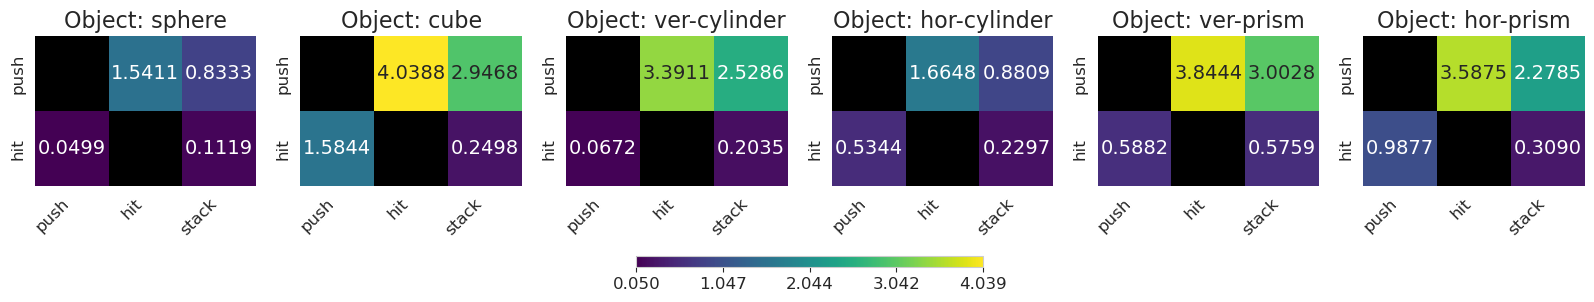

In [44]:
# -----------------------------
# 1. Load & aggregate 10 seeds
# -----------------------------
all_dicts = []
seeds = [8302, 2766, 257, 7600, 6657, 8226, 6841, 4908, 1321, 7857]
num_seeds = len(seeds)

for seed in seeds:
    # Replace the filename pattern as appropriate
    file_path = f"seed-{seed}-transfer-one-obj.npy"
    data = np.load(file_path, allow_pickle=True).item()
    all_dicts.append(data)

# -----------------------------
# 2. Average the nested dicts
# -----------------------------
# We'll create an averaged dictionary (average_dict)
average_dict = {}

for seed_dict in all_dicts:
    for obj_name, affected_tasks_dict in seed_dict.items():
        if obj_name not in average_dict:
            average_dict[obj_name] = {}
        for affected_task, affecting_tasks_dict in affected_tasks_dict.items():
            if affected_task not in average_dict[obj_name]:
                average_dict[obj_name][affected_task] = {}
            for affecting_task, diff_value in affecting_tasks_dict.items():
                if affecting_task not in average_dict[obj_name][affected_task]:
                    average_dict[obj_name][affected_task][affecting_task] = 0.0
                # Accumulate the difference value
                average_dict[obj_name][affected_task][affecting_task] += diff_value * 100 # (cm)

# Now divide by the number of seeds to get the average
for obj_name, affected_tasks_dict in average_dict.items():
    for affected_task, affecting_tasks_dict in affected_tasks_dict.items():
        for affecting_task in affecting_tasks_dict:
            average_dict[obj_name][affected_task][affecting_task] /= num_seeds

# -----------------------------
# 3. Prepare for visualization
# -----------------------------
# Suppose we know there are exactly 3 tasks (any labels you have):
task_row = ["push", "hit"]
task_column = ["push", "hit", "stack"]

# We'll gather all objects from the averaged dictionary
objects_list = list(average_dict.keys())
num_objects = len(objects_list)

# We'll gather all off-diagonal values to find global min and max
all_values = []
for obj_name in objects_list:
    for affected_task in task_row:
        for affecting_task in task_column:
            if affected_task != affecting_task:
                val = average_dict[obj_name][affected_task].get(affecting_task, 0.0)
                all_values.append(val)

# Compute global min and max to ensure a shared color scale
global_min = min(all_values) if all_values else 0.0
global_max = max(all_values) if all_values else 1.0

# -----------------------------
# 4. Plot each object as 3x3
# -----------------------------
fig, axes = plt.subplots(
    1, num_objects,
    figsize=(20, 3),  # Adjust figure size to fit subplots
    squeeze=False
)

for idx, obj_name in enumerate(objects_list):
    ax = axes[0, idx]  # We used a single row: row=0, column=idx
    
    # Initialize a 3x3 matrix for this object
    matrix = np.zeros((2, 3), dtype=float)
    
    # Fill the matrix:
    #   rows => affected task (i)
    #   cols => affecting task (j)
    #
    # The diagonal is 0 by definition, so if row == col: 0
    # Otherwise, use the difference in average_dict
    for i, affected_task in enumerate(task_row):
        for j, affecting_task in enumerate(task_column):
            if i != j:
                # Safely get the value; default to 0 if not found
                matrix[i, j] = average_dict[obj_name][affected_task].get(affecting_task, 0.0)
            else:
                matrix[i, j] = np.nan
    mask = np.isnan(matrix)
    
    a = sns.heatmap(
        matrix, 
        ax=ax, 
        mask=mask,
        annot=True, 
        fmt=".4f", 
        cmap="viridis", 
        vmin=global_min,   # use global min
        vmax=global_max,   # use global max
        cbar=False,        # disable individual subplot colorbar
        xticklabels=task_column, 
        yticklabels=task_row,
        annot_kws={'size': 14},   # Increase annotation (cell text) size
    )
    a.set_facecolor('black')
    a.grid(False)
    
     # Rotate X labels if desired
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    ax.set_title(f"Object: {obj_name}", fontsize=16)
    ax.tick_params(axis='both', labelsize=12)

sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(vmin=global_min, vmax=global_max)
)
sm.set_array([])  # Required for older matplotlib versions

# Place the colorbar below all subplots (horizontal)
cbar = fig.colorbar(
    sm,
    ax=axes.ravel().tolist(),      # all subplot axes
    orientation='horizontal',
    fraction=0.05,                 # thickness as a fraction of the plot
    pad=0.3,                       # space between subplots & colorbar
    aspect=30                      # aspect ratio can help increase length
)
n_ticks = 5
ticks = np.linspace(global_min, global_max, n_ticks)
cbar.set_ticks(ticks)
# Adjust tick font size
cbar.ax.tick_params(labelsize=12)

# plt.tight_layout()
plt.savefig("one-obj-transfer.png", bbox_inches='tight')
plt.show()
